### Predicting players rating


In this project you are going to predict the overall rating of soccer player based on their attributes such as 'crossing', 'finishing etc. The dataset you are going to use is from European Soccer Database (https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than 10,000 players for European professional soccer seasons from 2008 to 2016. Download the data in the same folder and run the following commmand to get it in the environment


### About the Dataset

The ultimate Soccer database for data analysis and machine learning The dataset comes in the form of an SQL database and contains statistics of about 25,000 football matches, from the top football league of 11 European Countries. It covers seasons from 2008 to 2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations, with player names and a pair of coordinates to indicate their position on the pitch. +25,000 matches +10,000 players 11 European Countries with their lead championship Seasons 2008 to 2016 Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates Team line up with squad formation (X, Y coordinates) Betting odds from up to 10 providers Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video games. It is not just the stats that come with a new version of the game but also the weekly updates. So for instance if a player has performed poorly over a period of time and his stats get impacted in FIFA, you would normally see the same in the dataset.

In [14]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
import datetime as dt
import math as math
import scipy.stats as stats
import statsmodels.api as sm

In [26]:
conn = sqlite3.connect('database.sqlite')
#cursor = conn.cursor()

In [27]:
dfPlayerAttributes = pd.read_sql_query('select * from Player_Attributes', conn)
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [29]:
dfPlayerAttributes.shape

(183978, 42)

In [30]:
# Get Column Names
columns = dfPlayerAttributes.columns
columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [31]:

# Understand data and its distribution or means
dfPlayerAttributes.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [32]:
# Understand data of Object type if they are categorical
dfPlayerAttributes.describe(include='object')

,date,preferred_foot,attacking_work_rate,defensive_work_rate
count,183978,183142,180748,183142
unique,197,2,8,19
top,2007-02-22 00:00:00,right,medium,medium
freq,11794,138409,125070,130846


In [33]:
# Date has 197 unique values so matches might have continued for 197 days
# All other soccer specific features has limited unique values like foot, attaching work rate or defensive work rate
# Except date and preferred foot, both other remaining variables looks ordinal

In [34]:
# Check for null values
dfPlayerAttributes.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [35]:
# It looks like there are total three counts of null values i.e. 836, 2713, 3230
# This means values might be missing for same kind of rows at least for 836 rows and 2713 rows

In [36]:

# Understand missing values if they can be filled with correct values
# Else drop the null values

In [37]:

# Find count of Ids of players where overall_rating is null
len(dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].player_api_id.unique())

756

In [38]:
# null values are not for 1 specific player but for 756 unique players out of 11060 total players

In [39]:

# Find count of Ids of players where volleys is null
len(dfPlayerAttributes[dfPlayerAttributes.volleys.isna()].player_api_id.unique())

1185

In [40]:
# null values are not for 1 specific player but for 1185 unique players ouf of 11060 total players

In [41]:
# Find other values of player ID who has some null values
dfPlayerAttributes[dfPlayerAttributes.player_api_id.isin(dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].player_api_id)].describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,14884.000000,14884.000000,14884.000000,14048.000000,14048.000000,14048.000000,14048.000000,14048.000000,14048.000000,13852.000000,...,13852.000000,14048.000000,14048.000000,14048.000000,13852.000000,14048.000000,14048.000000,14048.000000,14048.000000,14048.000000
mean,91188.755912,132274.953440,43580.244558,69.869305,72.659952,57.375214,52.464479,59.797409,64.137173,52.988666,...,61.142001,58.730923,47.889166,51.748719,48.858721,14.116031,16.035521,24.615746,16.313924,16.492526
std,52695.904461,54038.074548,38294.450242,6.156973,6.492969,17.003262,18.918962,16.243974,13.500282,17.864068,...,13.946435,15.738228,21.337472,21.124845,21.507567,15.813596,15.044045,23.735110,15.319779,16.157266
min,479.000000,61.000000,2907.000000,38.000000,44.000000,5.000000,5.000000,2.000000,7.000000,5.000000,...,5.000000,5.000000,4.000000,4.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,43061.750000,111085.000000,29673.000000,66.000000,68.000000,49.000000,39.000000,52.000000,60.000000,43.000000,...,54.000000,51.000000,25.000000,32.000000,27.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,92492.500000,152961.000000,37779.000000,70.000000,73.000000,61.000000,56.000000,63.000000,66.000000,57.000000,...,64.000000,62.000000,52.000000,57.000000,53.000000,10.000000,12.000000,12.000000,12.000000,12.000000
75%,137577.250000,171016.000000,41318.000000,74.000000,77.000000,70.000000,67.000000,71.000000,73.000000,66.000000,...,71.000000,70.000000,67.000000,71.000000,68.000000,13.000000,20.000000,48.000000,20.000000,20.000000
max,183488.000000,215569.000000,451941.000000,90.000000,93.000000,93.000000,97.000000,98.000000,97.000000,89.000000,...,96.000000,96.000000,91.000000,93.000000,92.000000,83.000000,85.000000,97.000000,90.000000,88.000000


In [42]:

# Although there are 1185 unique null values but there are 14884 rows of similar player_api_id
# That means not all data of a plyer missing, but only some data for some players are missing

In [43]:
dfMissingByPlayer = dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].groupby(by='player_api_id').agg({'player_api_id': 'count'})
#dfMissingByPlayer.columns = dfMissingByPlayer.columns.droplevel()
dfMissingByPlayer.columns = ['missing_rows_count']
dfMissingByPlayer = dfMissingByPlayer.reset_index()
dfMissingByPlayer.head()

,player_api_id,missing_rows_count
0,2907,1
1,3517,1
2,5243,1
3,5247,1
4,6864,1


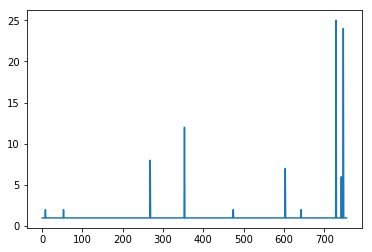

In [44]:

plt.plot(dfMissingByPlayer.missing_rows_count)

In [45]:
# It looks like 10-12 players has missing value more than 1 however rest all have missing value just 1

In [46]:

# Lets find count of those who has missing values more than 1
dfMissingByPlayer[dfMissingByPlayer.missing_rows_count > 1]

,player_api_id,missing_rows_count
8,11285,2
53,23019,2
268,32968,8
353,37254,12
474,39136,2
603,42116,7
642,46256,2
729,110189,25
742,163838,6
747,193866,24


In [47]:
# Total 10 players who has missing values, lets drop them at this time but we will look at them later on how to imputate them

In [48]:
# Lets find out null values after dropping or removing null values for overall_rating
dfPlayerAttributes[dfPlayerAttributes.overall_rating.notnull()].isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
attacking_work_rate    2394
defensive_work_rate       0
crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                1877
dribbling                 0
curve                  1877
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                1877
reactions                 0
balance                1877
shot_power                0
jumping                1877
stamina                   0
strength                  0
long_shots                0
aggression                0
interceptions             0
positioning               0
vision                 1877
penalties                 0
marking                   0
standing_tackle     

In [49]:
# Still there are 2394 rows with missing attacking_work_rate values. Lets drop them, we will find reason for them later

In [50]:
dfPlayerAttributes[dfPlayerAttributes.attacking_work_rate.notnull()].isna().sum()

id                       0
player_fifa_api_id       0
player_api_id            0
date                     0
overall_rating           0
potential                0
preferred_foot           0
attacking_work_rate      0
defensive_work_rate      0
crossing                 0
finishing                0
heading_accuracy         0
short_passing            0
volleys                394
dribbling                0
curve                  394
free_kick_accuracy       0
long_passing             0
ball_control             0
acceleration             0
sprint_speed             0
agility                394
reactions                0
balance                394
shot_power               0
jumping                394
stamina                  0
strength                 0
long_shots               0
aggression               0
interceptions            0
positioning              0
vision                 394
penalties                0
marking                  0
standing_tackle          0
sliding_tackle         394
g

In [51]:
#Still dropping by just attacking_work_rate leaves 394 null vlues at few columns. THATS IT, LETS DROP ALL and CONTINUE regression

In [52]:
dfPlayerAttributes = dfPlayerAttributes.dropna()
dfPlayerAttributes.isna().sum()

id                     0
player_fifa_api_id     0
player_api_id          0
date                   0
overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0


In [53]:
# No null values

In [54]:
dfPlayerAttributes.shape

(180354, 42)

In [55]:
# Lets drop ID columns and convert date variable into readable date

In [56]:
dfPlayerAttributes.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [57]:
impColumns = ['date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
              'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
              'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility',
              'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
              'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
              'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

In [58]:
# Lets convert date with timestamp values into simple dates
dfPlayerAttributes['date'] = pd.to_datetime(dfPlayerAttributes['date'])
dfPlayerAttributes[impColumns].head()

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [59]:
# Now lets start visualization and statistics

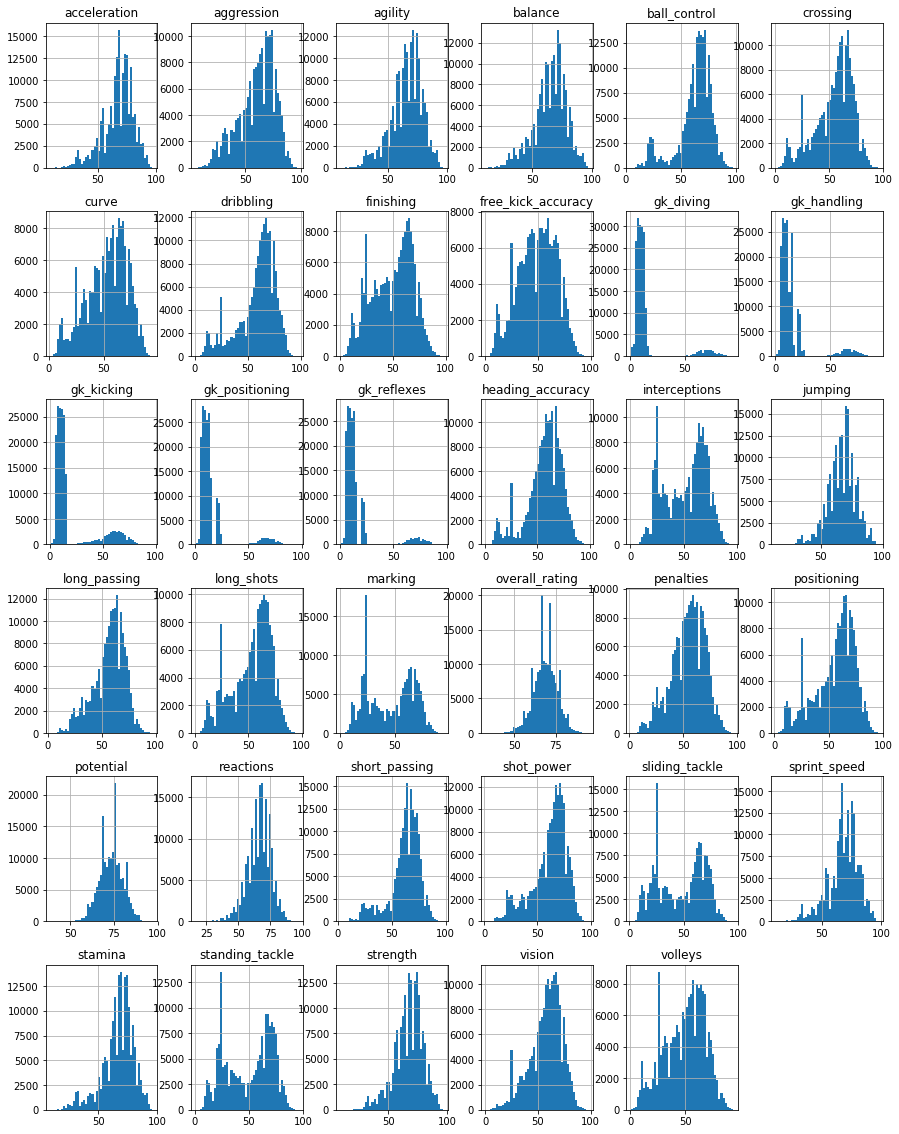

In [60]:
dfPlayerAttributes[impColumns].hist(bins=50, figsize=(15,20))
plt.show()

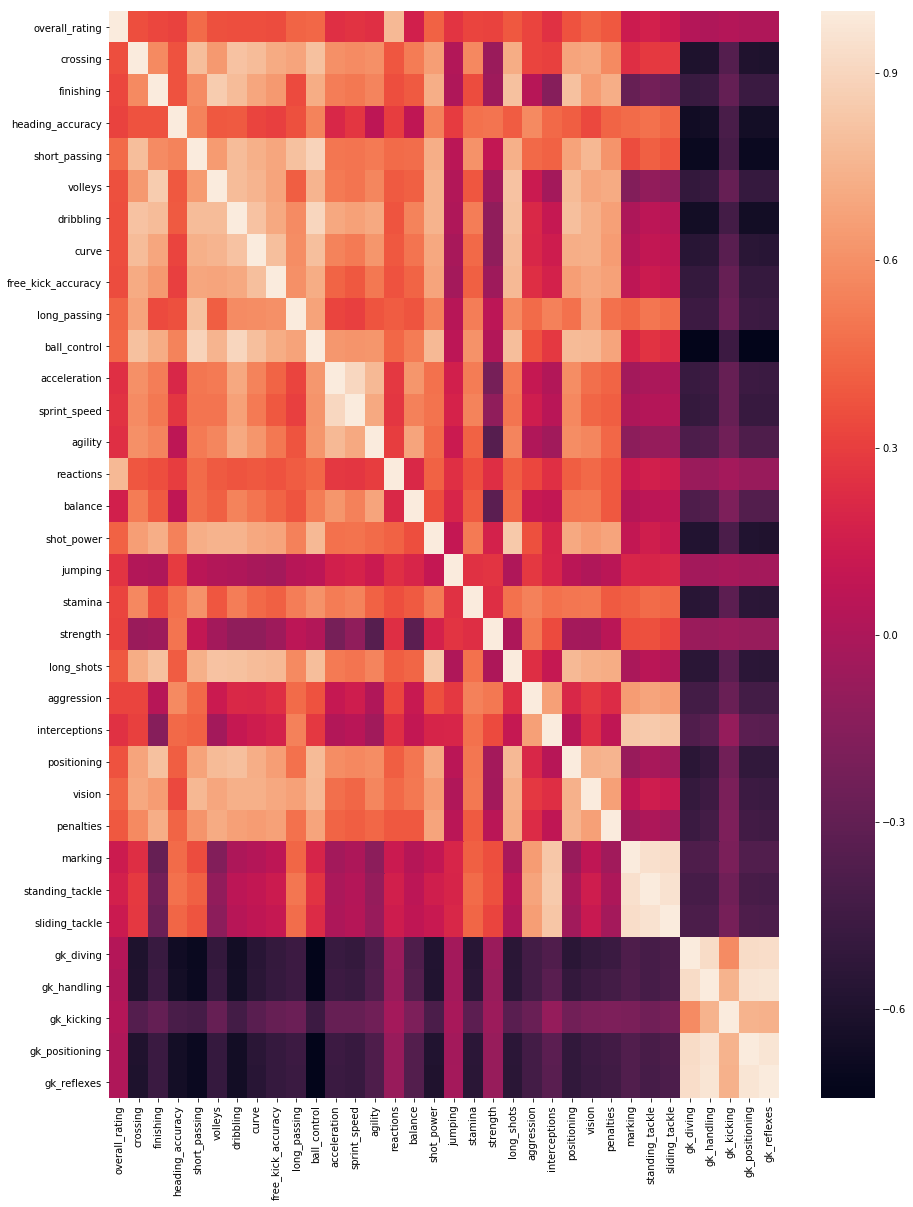

In [64]:
#fitsize
# Use pd.to_datetime to convert 
fig, ax = plt.subplots(figsize=(15,20))
sns.heatmap(dfPlayerAttributes[impColumns].corr())

In [65]:
#Lets drop potential because its similar to overall_Rating and it has highest correlation with dependant variable but it is same as dependant variable

In [ ]:
impColumns.remove('potential')

In [68]:
impColumns.remove('overall_rating')

In [ ]:
# Lets convert categorical features into numerical using dummies or factorize because skilearn doesnt allow to train model

In [69]:
dfPlayerAttributes[impColumns].describe(include='object')

,preferred_foot,attacking_work_rate,defensive_work_rate
count,180354,180354,180354
unique,2,8,18
top,right,medium,medium
freq,136247,125070,130846


In [70]:
labels, unique = pd.factorize(dfPlayerAttributes.preferred_foot)
unique

Index(['right', 'left'], dtype='object')

In [71]:
labels, unique = pd.factorize(dfPlayerAttributes.attacking_work_rate)
unique

Index(['medium', 'high', 'low', 'None', 'le', 'norm', 'stoc', 'y'], dtype='object')

In [72]:
labels, unique = pd.factorize(dfPlayerAttributes.defensive_work_rate)
unique

Index(['medium', 'high', 'low', '5', 'ean', 'o', '1', 'ormal', '7', '2', '8',
       '4', 'tocky', '0', '3', '6', '9', 'es'],
      dtype='object')

In [73]:
# From above, it looks like data in these categorical variables are not ordinal and some looks junk data

In [74]:
# STILL CONTINUE WITH DUMMIES FOR ALL AND BUILD FIRST MODELTO GET THE INITIAL ACCURACY AND PREDICTION

In [75]:

dummyDefensive = pd.get_dummies(dfPlayerAttributes.defensive_work_rate, prefix='defensive', drop_first=True)

In [76]:

dummyAttacking = pd.get_dummies(dfPlayerAttributes.attacking_work_rate, prefix='attacking', drop_first=True)

In [77]:
dummyPrefFoot = pd.get_dummies(dfPlayerAttributes.preferred_foot, prefix='prefFoot', drop_first=True)

In [78]:
dfPlayerAttributes = dfPlayerAttributes.join(dummyDefensive)

In [79]:
dfPlayerAttributes = dfPlayerAttributes.join(dummyAttacking)
dfPlayerAttributes = dfPlayerAttributes.join(dummyPrefFoot)

In [80]:
impColumns.extend(dummyDefensive.columns.values)
impColumns.extend(dummyAttacking.columns.values)
impColumns.extend(dummyPrefFoot.columns.values)

In [81]:
impColumns.remove('date')
impColumns.remove('defensive_work_rate')
impColumns.remove('attacking_work_rate')
impColumns.remove('preferred_foot')

In [82]:
x_train, x_test, y_train, y_test = train_test_split(dfPlayerAttributes[impColumns], dfPlayerAttributes['overall_rating'], test_size=0.3
                                                   ,random_state=12345)

In [83]:
x_train.shape

(126247, 58)

In [84]:
y_train.shape

(126247,)

In [85]:
lrModel = LinearRegression()

In [86]:
lrModel.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:

lrModel.score(x_train, y_train)

0.7860557292656735

In [88]:
lrModel.score(x_test, y_test)

0.7888279632214655

In [89]:
y_predicted = lrModel.predict(x_test)

In [90]:
y_test.shape

(54107,)

In [91]:
print('Error in prediction is ', ((y_predicted-y_test)**2).sum()/y_test.shape[0])

Error in prediction is  10.54000231135133


### After Data Cleaning - Fit model again

In [92]:
# Lets convert date with timestamp values into simple dates
dfPlayerAttributes['new_date'] = pd.to_datetime(dfPlayerAttributes['date'])
dfPlayerAttributes.drop(columns='date', inplace=True)
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,defensive_tocky,attacking_high,attacking_le,attacking_low,attacking_medium,attacking_norm,attacking_stoc,attacking_y,prefFoot_right,new_date
0,1,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,0,0,0,0,1,0,0,0,1,2016-02-18
1,2,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,0,0,0,0,1,0,0,0,1,2015-11-19
2,3,218353,505942,62.0,66.0,right,medium,medium,49.0,44.0,...,0,0,0,0,1,0,0,0,1,2015-09-21
3,4,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,0,0,0,0,1,0,0,0,1,2015-03-20
4,5,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,0,0,0,0,1,0,0,0,1,2007-02-22


In [93]:
dfPlayerAttributes['Year'] = dfPlayerAttributes['new_date'].dt.year
dfPlayerAttributes['Month'] = dfPlayerAttributes['new_date'].dt.month
dfPlayerAttributes.drop(columns='new_date', inplace=True)
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,attacking_high,attacking_le,attacking_low,attacking_medium,attacking_norm,attacking_stoc,attacking_y,prefFoot_right,Year,Month
0,1,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,0,0,0,1,0,0,0,1,2016,2
1,2,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,0,0,0,1,0,0,0,1,2015,11
2,3,218353,505942,62.0,66.0,right,medium,medium,49.0,44.0,...,0,0,0,1,0,0,0,1,2015,9
3,4,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,0,0,0,1,0,0,0,1,2015,3
4,5,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,0,0,0,1,0,0,0,1,2007,2


In [94]:
catObjects = dfPlayerAttributes.dtypes =='object'
catColumns = catObjects[catObjects.values].index.values
catColumns

array(['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'],
      dtype=object)

preferred_foot
****************************************
right    136247
left      44107
Name: preferred_foot, dtype: int64
attacking_work_rate
****************************************
medium    125070
high       42823
low         8569
None        3317
norm         317
y             94
stoc          86
le            78
Name: attacking_work_rate, dtype: int64
defensive_work_rate
****************************************
medium    130846
high       27041
low        18432
o           1328
1            421
2            334
ormal        317
3            243
5            231
7            207
0            188
6            179
9            143
4            116
es            94
tocky         86
ean           78
8             70
Name: defensive_work_rate, dtype: int64


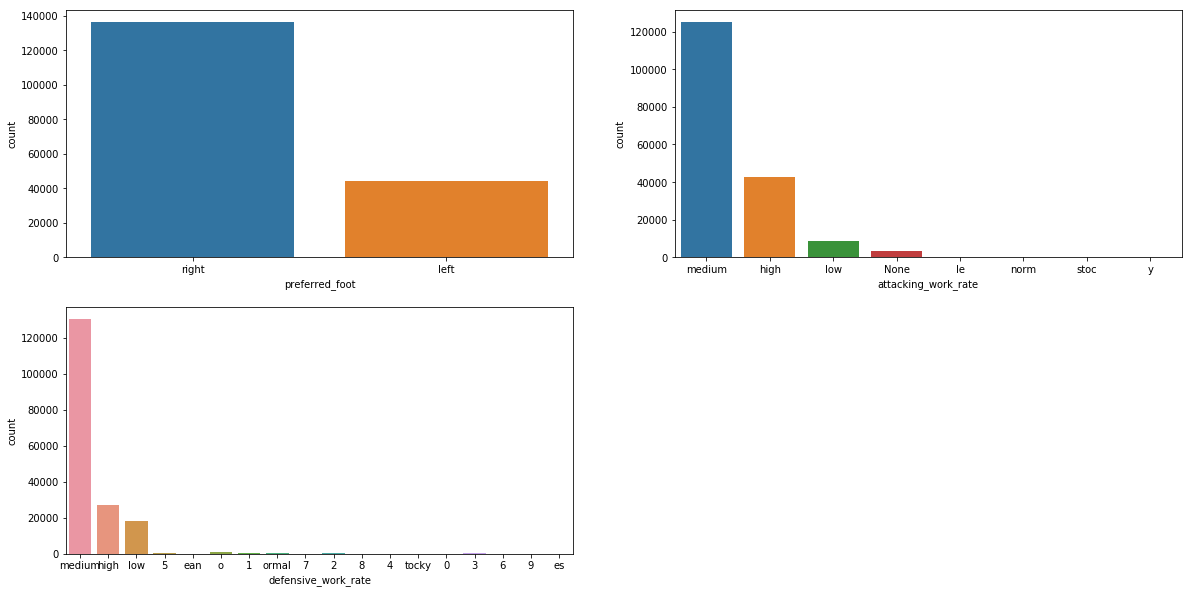

In [95]:
plt.figure(figsize=(20,10))

for i in range(0,len(catColumns)):
        plt.subplot(2,2,i+1)
        sns.countplot(x=catColumns[i], data=dfPlayerAttributes)

for i in range(0,len(catColumns)):
        print(catColumns[i])
        print('*'*40)
        print(dfPlayerAttributes[catColumns[i]].value_counts())
        print('='*40)

In [96]:
# Although we should drop lowest values in a categorical variable but only after statistical tests for mean and variance
# But we will do that later and timebeing we will drop them

In [97]:
dfPlayerAttributes.loc[dfPlayerAttributes.defensive_work_rate.isin(['_0', 'o']) == True, 'defensive_work_rate'] = 'low'

In [98]:
dfPlayerAttributes.defensive_work_rate.unique()

array(['medium', 'high', 'low', '5', 'ean', '1', 'ormal', '7', '2', '8',
       '4', 'tocky', '0', '3', '6', '9', 'es'], dtype=object)

In [99]:
dfPlayerAttributes = dfPlayerAttributes[dfPlayerAttributes.defensive_work_rate.isin(['medium', 'high', 'low']) == True]

In [100]:
dfPlayerAttributes = dfPlayerAttributes[dfPlayerAttributes.attacking_work_rate.isin(['medium', 'high', 'low']) == True]

In [101]:
dfPlayerAttributes.defensive_work_rate.unique()

array(['medium', 'high', 'low'], dtype=object)

In [102]:
dfPlayerAttributes.attacking_work_rate.unique()

array(['medium', 'high', 'low'], dtype=object)

In [103]:
replaced, unique = pd.factorize(dfPlayerAttributes.attacking_work_rate)
replaced

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [104]:
dfPlayerAttributes['New_Attacking_WR'] = replaced

In [105]:
replaced, unique = pd.factorize(dfPlayerAttributes.defensive_work_rate)
replaced

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [106]:
dfPlayerAttributes['New_Defensive_WR'] = replaced

In [107]:
dfPlayerAttributes.drop(columns=['attacking_work_rate', 'defensive_work_rate'], inplace=True)

In [108]:

dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,crossing,finishing,heading_accuracy,short_passing,...,attacking_low,attacking_medium,attacking_norm,attacking_stoc,attacking_y,prefFoot_right,Year,Month,New_Attacking_WR,New_Defensive_WR
0,1,218353,505942,67.0,71.0,right,49.0,44.0,71.0,61.0,...,0,1,0,0,0,1,2016,2,0,0
1,2,218353,505942,67.0,71.0,right,49.0,44.0,71.0,61.0,...,0,1,0,0,0,1,2015,11,0,0
2,3,218353,505942,62.0,66.0,right,49.0,44.0,71.0,61.0,...,0,1,0,0,0,1,2015,9,0,0
3,4,218353,505942,61.0,65.0,right,48.0,43.0,70.0,60.0,...,0,1,0,0,0,1,2015,3,0,0
4,5,218353,505942,61.0,65.0,right,48.0,43.0,70.0,60.0,...,0,1,0,0,0,1,2007,2,0,0


In [109]:

dfPlayerAttributes.isna().any()

id                    False
player_fifa_api_id    False
player_api_id         False
overall_rating        False
potential             False
preferred_foot        False
crossing              False
finishing             False
heading_accuracy      False
short_passing         False
volleys               False
dribbling             False
curve                 False
free_kick_accuracy    False
long_passing          False
ball_control          False
acceleration          False
sprint_speed          False
agility               False
reactions             False
balance               False
shot_power            False
jumping               False
stamina               False
strength              False
long_shots            False
aggression            False
interceptions         False
positioning           False
vision                False
                      ...  
gk_reflexes           False
defensive_1           False
defensive_2           False
defensive_3           False
defensive_4         

In [110]:
# This is a great finding, all null values were there only for those who had attacking or defensive different than 'low' 'medium' 'high'
# Thats why they got dropped

In [111]:
dfPlayerAttributes.describe(include='object')

,preferred_foot
count,176161
unique,2
top,right
freq,133102


In [112]:
dfPrefFoot = pd.get_dummies(dfPlayerAttributes.preferred_foot, prefix='prefferedFoot')
dfPrefFoot.shape

(176161, 2)

In [113]:

dfPlayerAttributes.shape

(176161, 68)

In [114]:

dfPlayerAttributes = dfPlayerAttributes.join(dfPrefFoot)

In [115]:
dfPlayerAttributes.drop(columns='preferred_foot', inplace=True)

In [116]:
impColumns = dfPlayerAttributes.columns.values.tolist()
impColumns.remove('id')
impColumns.remove('player_fifa_api_id')
impColumns.remove('player_api_id')
impColumns.remove('potential')
impColumns.remove('overall_rating')

### Apply model

In [117]:
x_train, x_test, y_train, y_test = train_test_split(dfPlayerAttributes[impColumns], dfPlayerAttributes['overall_rating'], test_size=0.3, random_state=12345)
x_train.shape

(123312, 64)

In [118]:
lm = LinearRegression()

In [119]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [120]:
lm.coef_

array([-8.35973883e-03,  1.39153396e-02,  1.01048070e-01,  6.78513245e-02,
        1.00712503e-03, -1.55419161e-02,  8.97442349e-03,  1.07129147e-02,
        1.84703601e-02,  2.25431139e-01,  4.14629436e-02,  5.06485601e-02,
       -1.52128116e-02,  2.75660895e-01,  4.33623648e-03,  2.42812548e-02,
        9.04472742e-03, -1.53475293e-02,  5.66015787e-02, -2.49608673e-02,
        1.04436026e-02,  2.19483113e-02, -2.15071794e-02,  1.65852872e-02,
        1.83726507e-02,  3.01050632e-02,  1.08748947e-02, -2.73807933e-02,
        1.87862575e-01,  5.63843921e-02, -1.16177965e-02,  7.62437218e-02,
        4.79224511e-02,  2.22044605e-16,  4.49293380e-16, -2.49800181e-16,
       -2.77555756e-16, -2.77555756e-17, -1.11022302e-16, -2.77555756e-17,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -9.44368868e-03,  1.09853380e-01, -1.00409692e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.66224125e-01,  0.00000000e+00,
        4.93875136e-01, -

In [121]:
lm.intercept_

-432.84944227208746

In [122]:
lm.score(x_train, y_train)

0.7921442846275699

In [123]:
y_predicted = lm.predict(x_test)

In [124]:
lm.score(x_test, y_test)

0.7896677788450712

In [125]:
math.sqrt(np.mean((y_predicted - y_test)**2))

3.198926223364593

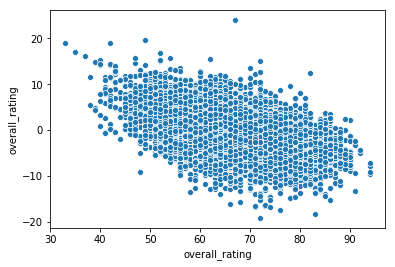

In [126]:
sns.scatterplot(y_test, (y_predicted - y_test))

In [ ]:
# It looks like there is some pattern in variance and predicted values
# Relationship looks slightly negative

## Lets test for importance of variables in model

In [127]:

dumm = pd.read_sql_query('select * from Player_Attributes', conn)

In [129]:
dumm.to_csv('SoccerData.csv')

In [130]:
model = sm.OLS(y_train, x_train).fit()


In [131]:
model.summary()

C:\Users\epadhak\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\epadhak\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\epadhak\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\epadhak\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 1.174e+04
Date:                Sun, 21 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:26:00   Log-Likelihood:            -3.1884e+05
No. Observations:              123312   AIC:                         6.378e+05
Df Residuals:                  123271   BIC:                         6.382e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
crossing               -0.0084      0.001     -7.163      0.000      -0.011      -0.006
finishing               0.0139      0.001     10.756      0.000       0.011       0.016
heading_accuracy        0.1010      0.001     89.337      0.000       0.099       0.103
short_passing           0.0679      0.002     34.891      0.000       0.064       0.072
volleys                 0.0010      0.001      0.873      0.383      -0.001       0.003
dribbling              -0.0155      0.002     -9.473      0.000      -0.019      -0.012
curve                   0.0090      0.001      7.977      0.000       0.007       0.011
free_kick_accuracy      0.0107      0.001     10.729      0.000       0.009       0.013
long_passing            0.0185      0.001     13.950      0.000       0.016       0.021
ball_control            0.2254      0.002    103.952      0.000       0.221       0.230
acceleration            0.0415      0.002     21.617      0.000       0.038       0.045
sprint_speed            0.0506      0.002     27.931      0.000       0.047       0.054
agility                -0.0152      0.001    -10.731      0.000      -0.018      -0.012
reactions               0.2757      0.001    187.039      0.000       0.273       0.279
balance                 0.0043      0.001      3.961      0.000       0.002       0.006
shot_power              0.0243      0.001     19.724      0.000       0.022       0.027
jumping                 0.0090      0.001      8.922      0.000       0.007       0.011
stamina                -0.0153      0.001    -13.384      0.000      -0.018      -0.013
strength                0.0566      0.001     47.958      0.000       0.054       0.059
long_shots             -0.0250      0.001    -19.439      0.000      -0.027      -0.022
aggression              0.0104      0.001     10.870      0.000       0.009       0.012
interceptions           0.0219      0.001     21.119      0.000       0.020       0.024
positioning            -0.0215      0.001    -19.291      0.000      -0.024      -0.019
vision                  0.0166      0.001     13.375      0.000       0.014       0.019
penalties               0.0184      0.001     17.449      0.000       0.016       0.020
marking                 0.0301      0.002     19.159      0.000       0.027       0.033
standing_tackle         0.0109      0.002      5.988      0.000       0.007       0.014
sliding_tackle         -0.0274      0.002    -17.671      0.000      -0.030      -0.024
gk_diving               0.1879      0.002     91.061      0.000       0.184       0.192
gk_handling             0.0564      0.003     21.131      0.000       0.051       0.062
gk_kicking             -0.0116      0.001    -11.937      0.000      -0.014      -0.010
gk_positioning          0.0762      0.003     28.705      0.000       0.071       0.081
gk_

### There is not a major improvement in R score. Lets split few variables into Categorical ordinal and try again

In [132]:
try:
    for i in dfPlayerAttributes.columns:    
        if(i.index("k_") > 0):
            print(i)
except:
    print('faield')

faield


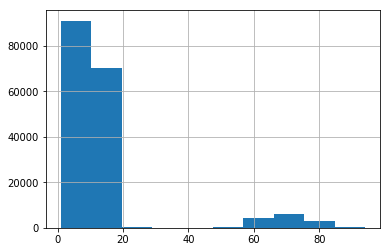

In [133]:
dfPlayerAttributes.gk_diving.hist()

In [134]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_diving <= 40, 'gk_diving'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_diving > 40, 'gk_diving'] = 1

In [135]:
dfPlayerAttributes.gk_diving.unique()

array([0., 1.])

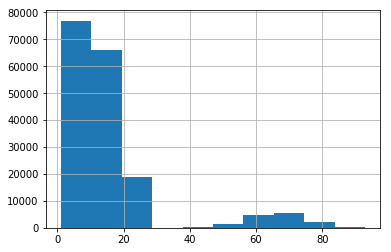

In [136]:
dfPlayerAttributes.gk_handling.hist()

In [137]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_handling <= 35, 'gk_handling'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_handling > 35, 'gk_handling'] = 1

In [138]:
dfPlayerAttributes.gk_handling.unique()

array([0., 1.])

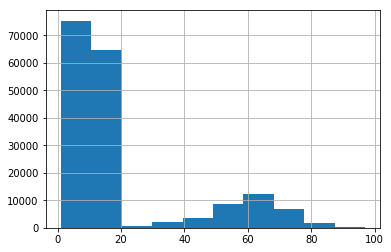

In [139]:
dfPlayerAttributes.gk_kicking.hist()

In [140]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_kicking <= 25, 'gk_kicking'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_kicking > 25, 'gk_kicking'] = 1

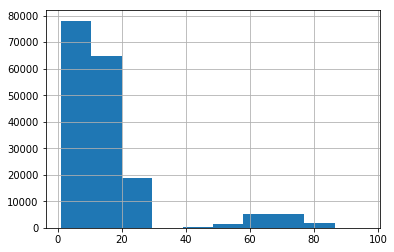

In [141]:
dfPlayerAttributes.gk_positioning.hist()

In [142]:

dfPlayerAttributes.loc[dfPlayerAttributes.gk_positioning <= 35, 'gk_positioning'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_positioning > 35, 'gk_positioning'] = 1

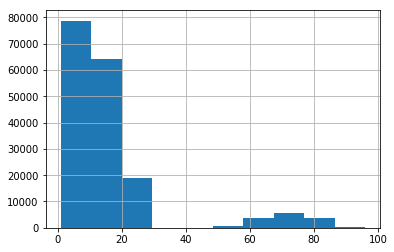

In [143]:
dfPlayerAttributes.gk_reflexes.hist()

In [144]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_reflexes <= 40, 'gk_reflexes'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_reflexes > 40, 'gk_reflexes'] = 1

In [145]:
x_train, x_test, y_train, y_test = train_test_split(dfPlayerAttributes[impColumns], dfPlayerAttributes['overall_rating'], test_size=0.3, random_state=12345)
x_train.shape

(123312, 64)

### Lets apply Model now - stats model

In [146]:
model = sm.OLS(y_train, x_train).fit()

In [147]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                 1.073e+04
Date:                Sun, 21 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:27:08   Log-Likelihood:            -3.2320e+05
No. Observations:              123312   AIC:                         6.465e+05
Df Residuals:                  123271   BIC:                         6.469e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
crossing               -0.0081      0.001     -6.670      0.000      -0.010      -0.006
finishing               0.0149      0.001     11.081      0.000       0.012       0.017
heading_accuracy        0.0949      0.001     80.758      0.000       0.093       0.097
short_passing           0.0647      0.002     32.183      0.000       0.061       0.069
volleys             -8.992e-05      0.001     -0.075      0.940      -0.002       0.002
dribbling              -0.0193      0.002    -11.370      0.000      -0.023      -0.016
curve                   0.0079      0.001      6.818      0.000       0.006       0.010
free_kick_accuracy      0.0069      0.001      6.700      0.000       0.005       0.009
long_passing            0.0175      0.001     12.606      0.000       0.015       0.020
ball_control            0.2181      0.002     97.014      0.000       0.214       0.223
acceleration            0.0425      0.002     21.390      0.000       0.039       0.046
sprint_speed            0.0554      0.002     29.497      0.000       0.052       0.059
agility                -0.0142      0.001     -9.663      0.000      -0.017      -0.011
reactions               0.2993      0.002    199.402      0.000       0.296       0.302
balance                 0.0045      0.001      3.992      0.000       0.002       0.007
shot_power              0.0245      0.001     19.211      0.000       0.022       0.027
jumping                 0.0130      0.001     12.411      0.000       0.011       0.015
stamina                -0.0200      0.001    -16.850      0.000      -0.022      -0.018
strength                0.0622      0.001     50.917      0.000       0.060       0.065
long_shots             -0.0273      0.001    -20.556      0.000      -0.030      -0.025
aggression              0.0098      0.001      9.808      0.000       0.008       0.012
interceptions           0.0257      0.001     23.659      0.000       0.024       0.028
positioning            -0.0232      0.001    -20.080      0.000      -0.025      -0.021
vision                  0.0254      0.001     19.803      0.000       0.023       0.028
penalties               0.0248      0.001     22.769      0.000       0.023       0.027
marking                 0.0324      0.002     19.894      0.000       0.029       0.036
standing_tackle         0.0060      0.002      3.213      0.001       0.002       0.010
sliding_tackle         -0.0276      0.002    -17.171      0.000      -0.031      -0.024
gk_diving               9.6360      1.133      8.504      0.000       7.415      11.857
gk_handling             1.5960      1.576      1.013      0.311      -1.493       4.685
gk_kicking              0.3806      0.041      9.260      0.000       0.300       0.461
gk_positioning          6.7202      1.290      5.208      0.000       4.191       9.249
gk_

In [148]:
# Since volleys and gk_handling has higher pvalue so they are redundant and do not provide any info. Lets drop them

In [149]:
impColumns.remove('gk_handling')
impColumns.remove('volleys')

In [150]:
model = sm.OLS(y_train, x_train[impColumns]).fit()

In [151]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Sun, 21 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:27:22   Log-Likelihood:            -3.2320e+05
No. Observations:              123312   AIC:                         6.465e+05
Df Residuals:                  123273   BIC:                         6.468e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
crossing               -0.0081      0.001     -6.674      0.000      -0.010      -0.006
finishing               0.0148      0.001     11.467      0.000       0.012       0.017
heading_accuracy        0.0949      0.001     80.984      0.000       0.093       0.097
short_passing           0.0647      0.002     32.189      0.000       0.061       0.069
dribbling              -0.0193      0.002    -11.392      0.000      -0.023      -0.016
curve                   0.0079      0.001      6.885      0.000       0.006       0.010
free_kick_accuracy      0.0069      0.001      6.696      0.000       0.005       0.009
long_passing            0.0175      0.001     12.686      0.000       0.015       0.020
ball_control            0.2181      0.002     97.019      0.000       0.214       0.223
acceleration            0.0425      0.002     21.398      0.000       0.039       0.046
sprint_speed            0.0554      0.002     29.496      0.000       0.052       0.059
agility                -0.0142      0.001     -9.668      0.000      -0.017      -0.011
reactions               0.2993      0.001    199.765      0.000       0.296       0.302
balance                 0.0045      0.001      3.992      0.000       0.002       0.007
shot_power              0.0245      0.001     19.294      0.000       0.022       0.027
jumping                 0.0130      0.001     12.416      0.000       0.011       0.015
stamina                -0.0200      0.001    -16.868      0.000      -0.022      -0.018
strength                0.0622      0.001     50.920      0.000       0.060       0.065
long_shots             -0.0274      0.001    -20.775      0.000      -0.030      -0.025
aggression              0.0098      0.001      9.810      0.000       0.008       0.012
interceptions           0.0257      0.001     23.668      0.000       0.024       0.028
positioning            -0.0232      0.001    -20.090      0.000      -0.025      -0.021
vision                  0.0254      0.001     19.841      0.000       0.023       0.028
penalties               0.0248      0.001     22.796      0.000       0.023       0.027
marking                 0.0324      0.002     19.957      0.000       0.029       0.036
standing_tackle         0.0060      0.002      3.210      0.001       0.002       0.010
sliding_tackle         -0.0276      0.002    -17.197      0.000      -0.031      -0.024
gk_diving              10.2945      0.928     11.095      0.000       8.476      12.113
gk_kicking              0.3806      0.041      9.273      0.000       0.300       0.461
gk_positioning          7.3995      1.103      6.710      0.000       5.238       9.561
gk_reflexes             2.4311      1.036      2.347      0.019       0.401       4.462
defensive_1         -8.313e-11   2.05e-12    -40.533      0.000   -8.72e-11   -7.91e-11
def

In [152]:
y_predicted = model.predict(x_test[impColumns])

In [153]:
model.conf_int()

,0,1
crossing,-1.043277e-02,-5.695864e-03
finishing,1.229033e-02,1.735782e-02
heading_accuracy,9.256943e-02,9.716130e-02
short_passing,6.077299e-02,6.865380e-02
dribbling,-2.265584e-02,-1.600438e-02
curve,5.670817e-03,1.018468e-02
free_kick_accuracy,4.890567e-03,8.938084e-03
long_passing,1.483645e-02,2.025870e-02
ball_control,2.136978e-01,2.225101e-01
acceleration,3.860616e-02,4.639176e-02


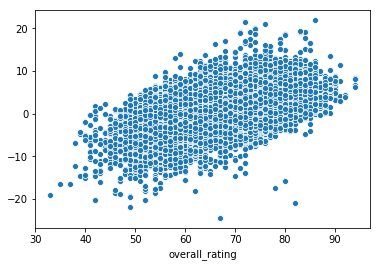

In [154]:
sns.scatterplot(y_test, (y_test - y_predicted))